In [1]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack
import pandas as pd
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR


c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
dades = read_csv('dadesSauMulti.csv', sep=';',header=0, index_col=0)

vol = dades['Volum']
tm = dades['TM']
hrm = dades['HRM']
ppt = dades['PPT']
pm = dades['PM']

# convert to [rows, columns] structure
vol = vol.reshape((len(vol), 1))
tm = tm.reshape((len(tm), 1))
hrm = hrm.reshape((len(hrm), 1))
ppt = ppt.reshape((len(ppt), 1))
pm = pm.reshape((len(pm), 1))


# horizontally stack columns
dataset = hstack((vol,tm,hrm,ppt,pm,vol))

scaler = MinMaxScaler(feature_range=(0, 1))
datasetN = scaler.fit_transform(dataset)

c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':
c:\users\manel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  de

In [3]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [4]:
def train_test (n_steps_in, n_steps_out, propTrainTest, dataset):
    
    n_steps_in, n_steps_out = n_steps_in, n_steps_out
    # split train test
    X, y = split_sequences(dataset, n_steps_in, n_steps_out)
    
    train_size = int(len(X) * propTrainTest)
    test_size = len(dataset) - train_size
    train_X, test_X = X[0:train_size,:], X[train_size:len(X),:]
    train_Y, test_Y = y[0:train_size,:], y[train_size:len(y),:]
    
    return (train_X, test_X, train_Y, test_Y)

In [5]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [6]:
n_steps_in = 20
n_steps_out = 15
propTrainTest = 0.8
train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)

In [7]:
# flatten input
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
test_X = test_X.reshape((test_X.shape[0], n_input))

In [8]:
from scipy.stats import uniform
from scipy.stats import randint
arbres=[]
profunditat=[]
max_features=[]
min_samples_split = []
min_samples_leaf = []
for i in range(500):
    arbres.append((randint.rvs(5, 500)))
    profunditat.append((randint.rvs(1, 121)))
    max_features.append((randint.rvs(1, 20)))
    min_samples_split.append((randint.rvs(2, 50)))
    min_samples_leaf.append((randint.rvs(1, 45)))
    


In [10]:
#Simulació RandomizedSearchCV per Random forest
resultat=[]

for arbre, profund, max_f, mss, msl in zip(arbres, profunditat, max_features, min_samples_split, min_samples_leaf):
    regr_rf = RandomForestRegressor(n_estimators=arbre, max_depth=profund, max_features=max_f, 
                                    min_samples_split = mss, min_samples_leaf=msl, random_state=2)
    regr_rf.fit(train_X, train_Y)
    # Predict on new data
    yhat = regr_rf.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT,arbre, profund, max_f, mss, msl)
    resultat.append((arbre, profund, max_f, mss, msl, RMSE_days,RMSE_TOT))
                 
    

6.997787945437852 214 68 5 9 30
6.937797127419335 36 6 16 7 13
6.883648025074672 39 6 16 25 34
6.843260146218019 338 9 10 33 18
7.138647994253288 477 46 16 14 6
6.839539128374606 329 113 9 20 33
6.83197164156739 195 69 6 14 10
7.14887575771447 481 112 5 3 42
6.8214251180161805 12 50 19 36 44
8.092019217636066 53 111 1 8 4
6.90324978336921 332 91 14 44 16
6.758029926477356 461 82 17 9 42
10.292465122017832 240 100 1 36 29
6.8741803247192355 152 120 16 34 23
6.868541368253545 340 107 14 23 13
6.891483264641394 430 110 15 25 31
6.902414426842475 322 54 13 25 12
6.907754479535542 161 57 19 16 38
9.885014559543144 354 61 1 13 26
6.766656234653836 469 95 17 26 39
6.798559645951848 442 99 5 34 18
6.809833261507233 230 106 7 26 7
10.943093831602265 242 106 1 10 42
6.884488604679553 119 34 15 36 17
10.65744280044695 90 34 1 29 44
6.888551425039514 452 111 17 15 23
6.9472958496457 404 109 4 46 13
6.823611055989787 235 35 16 34 29
15.119791400849042 420 2 2 20 18
6.905169826629437 414 77 19 37 28

6.851198780171485 148 57 13 2 25
7.144071742667954 324 76 15 6 5
7.20228245137016 232 49 14 16 1
8.321200966264609 31 118 2 35 41
6.887909972906312 479 13 19 40 39
6.910272418209025 445 91 4 47 1
6.796317244334052 361 81 11 46 13
6.828858897198902 481 114 13 38 22
6.78396835251584 495 55 12 33 16
7.354813961675289 312 75 4 35 42
7.0722328472660365 111 93 16 11 7
7.066972538336633 393 68 15 30 7
6.921038886103924 61 30 13 18 44
6.787149039751389 393 22 7 40 24
7.082707452556256 145 84 17 10 17
6.860321412812399 188 73 13 24 17
6.879036403280482 475 67 19 17 34
6.986884627027528 396 97 15 23 11
7.03843057028165 33 118 6 25 35
6.9121596471282505 392 56 14 4 19
6.974091661073608 51 89 13 49 39
6.948373351085558 336 72 5 2 27
6.883925966874895 349 96 19 38 33
6.881952070526993 245 42 19 10 29
7.189726490696523 353 29 4 6 28
6.851772749728621 134 86 4 31 3
6.830857837852713 89 66 11 39 34
6.826056600149234 308 65 16 29 37
6.906922770464397 289 85 18 3 35
7.293308336850633 425 86 4 30 33
6.76

7.156350204540378 83 75 13 7 7
6.995204842415902 338 6 7 2 24
7.048386955852376 400 58 14 33 5
6.952239563020584 39 30 12 19 38
6.8897715995823265 485 13 19 40 27


In [11]:
varlist = []
for i in range(len(arbres)):
    varlist.append(resultat[i])
    
resultFinal = pd.DataFrame(varlist)
resultFinal.columns=['n_estimators','max_depth',  'max_feautres','min_samples_split','min_samples_leaf','RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,n_estimators,max_depth,max_feautres,min_samples_split,min_samples_leaf,RMSE_dies,RMSE_total
0,144,91,7,11,18,"[3.331891322408085, 3.854881858396864, 4.37332...",6.713384
1,35,11,9,30,18,"[3.0392241287132147, 3.614613320383341, 4.1812...",6.724544
2,405,67,9,19,16,"[3.066480274820971, 3.6373251306535486, 4.1986...",6.725707
3,253,32,6,14,11,"[3.409256508140719, 3.9234760825567294, 4.4312...",6.729921
4,496,14,11,43,23,"[2.925488722510197, 3.514343539063133, 4.09512...",6.734072
5,241,72,11,45,20,"[2.9196981408959375, 3.511261206306606, 4.0949...",6.736005
6,413,48,7,20,18,"[3.358937906867463, 3.886915786949745, 4.40711...",6.736022
7,136,63,11,37,23,"[2.987097208393086, 3.566908296978582, 4.14250...",6.742886
8,104,109,17,33,40,"[2.7905815618509324, 3.425822337067208, 4.0468...",6.745319
9,174,12,10,26,36,"[3.2669664225228146, 3.82548881075745, 4.36638...",6.750142


In [12]:
# Simulació GridSearchCV random forest
import numpy as np
resultatsf = []
arbres = np.arange(140,151,1)
profunditat = np.arange(85,96,1)
max_features = np.arange(5,10,1)

for arbre in arbres:
    for profund in profunditat:
        resultat = []
        for max_f in max_features:
            regr_rf = RandomForestRegressor(n_estimators=arbre, max_depth=profund, max_features=max_f, 
                                    min_samples_split = 11, min_samples_leaf=18, random_state=2)
            regr_rf.fit(train_X, train_Y)
            # Predict on new data
            yhat = regr_rf.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
            # invertim prediccions per tenir-les en l'escala original
            yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
            test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
            #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
            dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
            inv_yhat = scaler.inverse_transform(dataset2)
            testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
            #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
            test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

            RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
            print(RMSE_TOT,arbre, profund, max_f)
            resultat.append((arbre, profund, max_f, RMSE_days,RMSE_TOT))

        resultatsf.append(resultat)


6.880945254786184 140 85 5
6.778934266979808 140 85 6
6.713096920783947 140 85 7
6.7109089194715965 140 85 8
6.825463452245497 140 85 9
6.880945254786184 140 86 5
6.778934266979808 140 86 6
6.713096920783947 140 86 7
6.7109089194715965 140 86 8
6.825463452245497 140 86 9
6.880945254786184 140 87 5
6.778934266979808 140 87 6
6.713096920783947 140 87 7
6.7109089194715965 140 87 8
6.825463452245497 140 87 9
6.880945254786184 140 88 5
6.778934266979808 140 88 6
6.713096920783947 140 88 7
6.7109089194715965 140 88 8
6.825463452245497 140 88 9
6.880945254786184 140 89 5
6.778934266979808 140 89 6
6.713096920783947 140 89 7
6.7109089194715965 140 89 8
6.825463452245497 140 89 9
6.880945254786184 140 90 5
6.778934266979808 140 90 6
6.713096920783947 140 90 7
6.7109089194715965 140 90 8
6.825463452245497 140 90 9
6.880945254786184 140 91 5
6.778934266979808 140 91 6
6.713096920783947 140 91 7
6.7109089194715965 140 91 8
6.825463452245497 140 91 9
6.880945254786184 140 92 5
6.778934266979808 140

6.79670780576149 145 90 9
6.8819335767751895 145 91 5
6.7692454281941545 145 91 6
6.706889364387936 145 91 7
6.711701332243134 145 91 8
6.79670780576149 145 91 9
6.8819335767751895 145 92 5
6.7692454281941545 145 92 6
6.706889364387936 145 92 7
6.711701332243134 145 92 8
6.79670780576149 145 92 9
6.8819335767751895 145 93 5
6.7692454281941545 145 93 6
6.706889364387936 145 93 7
6.711701332243134 145 93 8
6.79670780576149 145 93 9
6.8819335767751895 145 94 5
6.7692454281941545 145 94 6
6.706889364387936 145 94 7
6.711701332243134 145 94 8
6.79670780576149 145 94 9
6.8819335767751895 145 95 5
6.7692454281941545 145 95 6
6.706889364387936 145 95 7
6.711701332243134 145 95 8
6.79670780576149 145 95 9
6.880573239013803 146 85 5
6.776824134081168 146 85 6
6.70180625635798 146 85 7
6.711530111095872 146 85 8
6.790967360268027 146 85 9
6.880573239013803 146 86 5
6.776824134081168 146 86 6
6.70180625635798 146 86 7
6.711530111095872 146 86 8
6.790967360268027 146 86 9
6.880573239013803 146 87 5

In [18]:
varlist = []
for i in range(len(arbres)):
    resultatsEpDe = pd.DataFrame(resultatsf[i])
    varlist.append(resultatsEpDe)
    
resultFinal = pd.concat(varlist)

resultFinal.columns=['n_estimators','max_depth',  'max_feautres','RMSE_dies', 'RMSE_total' ]
resultFinal = resultFinal.sort_values(by='RMSE_total', ascending=True)
resultFinal = resultFinal.reset_index(drop=True)

resultFinal[0:15]

,n_estimators,max_depth,max_feautres,RMSE_dies,RMSE_total
0,140,91,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
1,140,85,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
2,140,92,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
3,140,90,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
4,140,95,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
5,140,86,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
6,140,89,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
7,140,94,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
8,140,93,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909
9,140,87,8,"[3.2001843947039497, 3.748921366309714, 4.2873...",6.710909


In [26]:
regr_rf = RandomForestRegressor(n_estimators=140, max_depth=91, max_features=8, 
                                    min_samples_split = 11, min_samples_leaf=18, random_state=2)
            
regr_rf.fit(train_X, train_Y)
# Predict on new data
yhat = regr_rf.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
# invertim prediccions per tenir-les en l'escala original
yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
#dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
inv_yhat = scaler.inverse_transform(dataset2)
testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
#test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

6.7109089194715965


In [22]:
import numpy as np
import matplotlib.pyplot as plt
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - Sau - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - Sau - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - Sau - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[14],3))


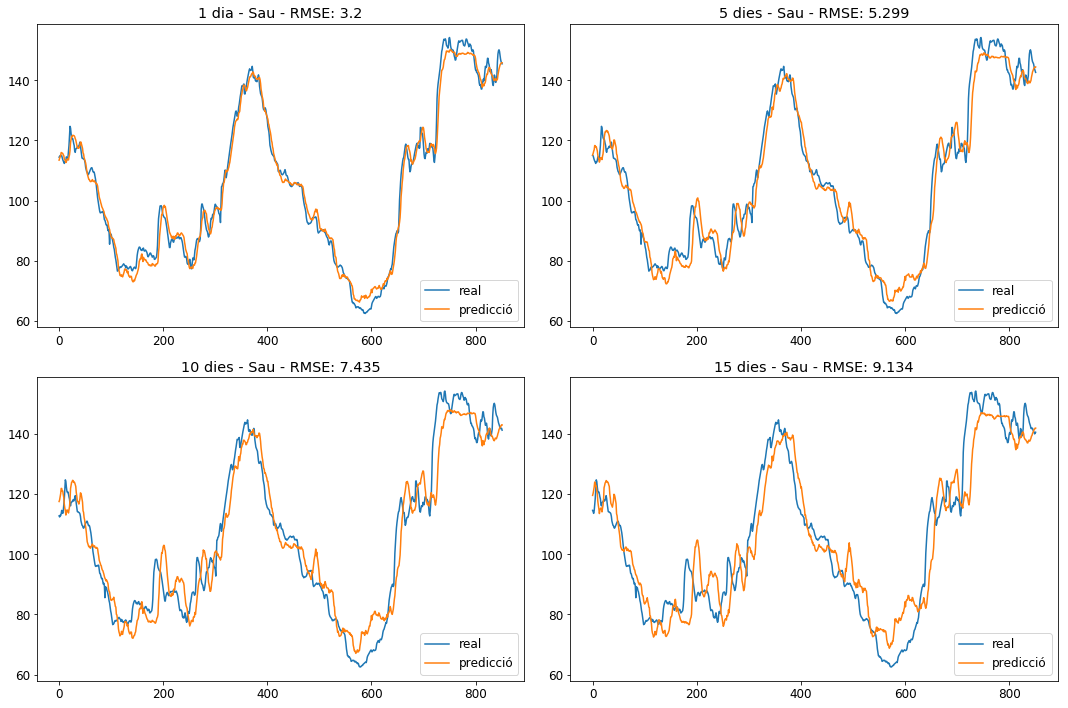

In [27]:
plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()

In [24]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

╒═════════╤═════════╤═════════╤═════════╤═════════╕
│   dia 1 │   dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞═════════╪═════════╪═════════╪═════════╪═════════╡
│ 3.20018 │ 3.74892 │ 4.28736 │ 4.80203 │ 5.29863 │
╘═════════╧═════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 5.76946 │ 6.21994 │ 6.64802 │ 7.05317 │  7.43547 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│  7.80073 │  8.15083 │  8.48935 │  8.81681 │  9.13432 │ 6.71091 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧═════════╛


In [13]:
import numpy as np
n_steps_in = np.arange(1,20,1)
n_steps_out = 15
propTrainTest = 0.8
resultat = []
for entrades in n_steps_in:
    train_X, test_X, train_Y, test_Y = train_test(entrades, n_steps_out, propTrainTest, datasetN)
    n_input = train_X.shape[1] * train_X.shape[2]
    train_X = train_X.reshape((train_X.shape[0], n_input))
    test_X = test_X.reshape((test_X.shape[0], n_input))
    if n_input <= 8:
        max_f=n_input
    else:
        max_f=8
        
    regr_rf = RandomForestRegressor(n_estimators=140, max_depth=91, max_features=max_f, 
                                    min_samples_split = 11, min_samples_leaf=18, random_state=2)
    regr_rf.fit(train_X, train_Y)
    # Predict on new data
    yhat = regr_rf.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
    # invertim prediccions per tenir-les en l'escala original
    yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
    test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
    #dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
    inv_yhat = scaler.inverse_transform(dataset2)
    testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
    #test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
    test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])
    RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
    print(RMSE_TOT, entrades)
    resultat.append((entrades, RMSE_TOT))

6.005523663015798 1
5.990376213814337 2
5.9655496284474925 3
5.990846692140162 4
5.954899577408061 5
6.042867123058606 6
6.106792719833504 7
6.118281224598445 8
6.133032175161528 9
6.223200353287492 10
6.24066307500095 11
6.28102762295616 12
6.411130763390254 13
6.482786157929916 14
6.465833302208238 15
6.5326926666426495 16
6.701659315108045 17
6.698877127879481 18
6.669865269821759 19


In [8]:
n_steps_in = 5
n_steps_out = 15
propTrainTest = 0.8

train_X, test_X, train_Y, test_Y = train_test(n_steps_in, n_steps_out, propTrainTest, datasetN)
n_input = train_X.shape[1] * train_X.shape[2]
train_X = train_X.reshape((train_X.shape[0], n_input))
test_X = test_X.reshape((test_X.shape[0], n_input))

regr_rf = RandomForestRegressor(n_estimators=140, max_depth=91, max_features=8, 
                                    min_samples_split = 11, min_samples_leaf=18, random_state=2)
            
regr_rf.fit(train_X, train_Y)
# Predict on new data
yhat = regr_rf.predict(test_X)        # invertim prediccions per tenir-les en l'escala original
# invertim prediccions per tenir-les en l'escala original
yhat2 = yhat.reshape((yhat.shape[0]*yhat.shape[1], 1))
test_Y2 = test_Y.reshape((test_Y.shape[0]*test_Y.shape[1], 1))
#dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
dataset2 = hstack((yhat2,yhat2,yhat2,yhat2,yhat2,test_Y2))
inv_yhat = scaler.inverse_transform(dataset2)
testPredict = inv_yhat[:,0].reshape(test_Y.shape[0], test_Y.shape[1])
#test_YR = inv_yhat[:,7].reshape(test_Y.shape[0], test_Y.shape[1])
test_YR = inv_yhat[:,5].reshape(test_Y.shape[0], test_Y.shape[1])

RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)

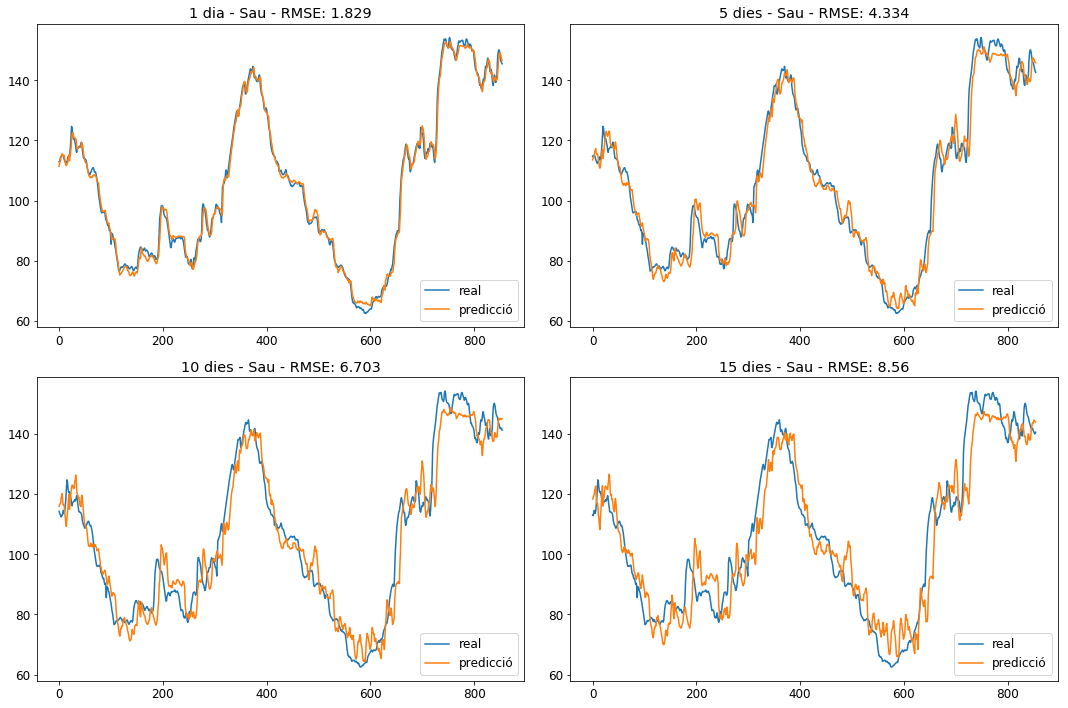

In [9]:
import numpy as np
import matplotlib.pyplot as plt
dies = list()
    # calculem RMSE per cada dia
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    dies.append((test_YR[:, i], testPredict[:, i]))

%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]
title1 = '1 dia - Sau - RMSE: '+str(round(RMSE_days[0],3))
title5 = '5 dies - Sau - RMSE: '+str(round(RMSE_days[4],3))
title10 = '10 dies - Sau - RMSE: '+str(round(RMSE_days[9],3))
title15 = '15 dies - Sau - RMSE: '+str(round(RMSE_days[14],3))

plt.rcParams.update({'font.size': 12})

plt.subplots_adjust(hspace=0.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# plot time signal:
axes[0, 0].set_title(title1)
axes[0, 0].plot(dies[0][0], label='real')
axes[0, 0].plot(dies[0][1], label='predicció')
axes[0, 0].legend(loc=4)

axes[0, 1].set_title(title5)
axes[0, 1].plot(dies[4][0], label='real')
axes[0, 1].plot(dies[4][1], label='predicció')
axes[0, 1].legend(loc=4)

axes[1, 0].set_title(title10)
axes[1, 0].plot(dies[9][0], label='real')
axes[1, 0].plot(dies[9][1], label='predicció')
axes[1, 0].legend(loc=4)

axes[1, 1].set_title(title15)
axes[1, 1].plot(dies[14][0], label='real')
axes[1, 1].plot(dies[14][1], label='predicció')
axes[1, 1].legend(loc=4)


fig.tight_layout()
plt.show()

In [10]:
from tabulate import tabulate
headers=[]
for i in range(len(RMSE_days)):
    headers.append('dia '+str(i+1))

headers.append('Total')
v = RMSE_days
ultim = v.append(RMSE_TOT)
table1 = tabulate([RMSE_days[0:5]], headers[0:5], tablefmt="fancy_grid")
table2 = tabulate([RMSE_days[5:10]], headers[5:10], tablefmt="fancy_grid")
table3 = tabulate([RMSE_days[10:16]], headers[10:16], tablefmt="fancy_grid")
#output
print(table1)
print(table2)
print(table3)

╒═════════╤═════════╤═════════╤═════════╤═════════╕
│   dia 1 │   dia 2 │   dia 3 │   dia 4 │   dia 5 │
╞═════════╪═════════╪═════════╪═════════╪═════════╡
│ 1.82939 │  2.5047 │ 3.15044 │ 3.75638 │ 4.33359 │
╘═════════╧═════════╧═════════╧═════════╧═════════╛
╒═════════╤═════════╤═════════╤═════════╤══════════╕
│   dia 6 │   dia 7 │   dia 8 │   dia 9 │   dia 10 │
╞═════════╪═════════╪═════════╪═════════╪══════════╡
│ 4.87139 │ 5.37882 │ 5.85723 │ 6.29783 │  6.70295 │
╘═════════╧═════════╧═════════╧═════════╧══════════╛
╒══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   dia 11 │   dia 12 │   dia 13 │   dia 14 │   dia 15 │   Total │
╞══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│  7.09178 │  7.46624 │  7.83353 │  8.19946 │  8.56047 │  5.9549 │
╘══════════╧══════════╧══════════╧══════════╧══════════╧═════════╛


In [11]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts_rquad(actual, predicted):
    scores = list()
    # calculem RMSE per cada dia
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        r_quad = r2_score(actual[:, i], predicted[:, i])
        mae = mean_absolute_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append((rmse,r_quad,mae,mse))
    # calcul global de RMSE
    s = 0
    r = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [12]:
RMSE_TOT, RMSE_days = evaluate_forecasts_rquad(test_YR,testPredict)
global_y = test_YR.reshape((test_YR.shape[0]*test_YR.shape[1], 1))
global_pred = testPredict.reshape((testPredict.shape[0]*testPredict.shape[1], 1))
r_quad = r2_score(global_y, global_pred)
rmse = sqrt(mean_squared_error(global_y, global_pred))
mse = mean_squared_error(global_y, global_pred)
mae = mean_absolute_error(global_y, global_pred)

res_globals=[rmse, r_quad, mae, mse]

resultsDF =  pd.DataFrame(RMSE_days)
resultsDF = resultsDF.T
resultsDF['Global'] = res_globals
resultsDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
resultsDF.rename(index={0:'RMSE',1:'R2',2:'MAE', 3:'MSE'}, inplace=True)
resultsDF = resultsDF.round(4)
display(resultsDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,1.8294,2.5047,3.1504,3.7564,4.3336,4.8714,5.3788,5.8572,6.2978,6.7029,7.0918,7.4662,7.8335,8.1995,8.5605,5.9549
R2,0.9949,0.9905,0.9850,0.9787,0.9718,0.9644,0.9567,0.9487,0.9409,0.9331,0.9253,0.9174,0.9092,0.9008,0.8921,0.9470
MAE,1.4366,1.9158,2.3686,2.8107,3.2557,3.6698,4.0736,4.4825,4.8623,5.2206,5.5477,5.8406,6.1279,6.4321,6.7438,4.3192
MSE,3.3467,6.2735,9.9253,14.1104,18.7800,23.7304,28.9317,34.3071,39.6626,44.9295,50.2934,55.7448,61.3643,67.2312,73.2816,35.4608


In [13]:
RMSE_TOT, RMSE_days = evaluate_forecasts(test_YR,testPredict)
v = RMSE_days
ultim = v.append(RMSE_TOT)

dades_diesDF=pd.DataFrame(v)
dades_diesDF=dades_diesDF.round(3)
dades_diesDF=dades_diesDF.T
dades_diesDF.columns=['dia 1','dia 2','dia 3','dia 4','dia 5','dia 6','dia 7','dia 8','dia 9','dia 10','dia 11','dia 12','dia 13','dia 14','dia 15', 'global']
dades_diesDF.rename(index={0:'RMSE'}, inplace=True)

display(dades_diesDF)

,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,global
RMSE,1.829,2.505,3.15,3.756,4.334,4.871,5.379,5.857,6.298,6.703,7.092,7.466,7.834,8.199,8.56,5.955


In [14]:
resultsDF.to_csv('rf-multi-sau.csv', sep=',', encoding='utf-8')